# Imagenet-pretrained EfficientNet

In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 2

env: CUDA_VISIBLE_DEVICES=2


Import necessary tools, again.`

In [53]:
import sys

sys.path.insert(0, '../batchflow')
sys.path.insert(0, '../src')
sys.path.insert(0, '../open-metric-learning')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms

import torch
from tqdm import tqdm

from oml.datasets.base import DatasetWithLabels
from oml.losses.triplet import TripletLossWithMiner
from oml.miners.inbatch_all_tri import AllTripletsMiner
from oml.samplers.balance import BalanceSampler
from oml.utils.images.images import imread_pillow
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from nbtools.core import get_notebook_name

from batchflow import plot, Notifier

from loader import ImagesDataset
from evaluator import MetricsEvaluator

Get notebook name and use it as an experiment name.

In [109]:
NAME = get_notebook_name()
NAME

'05_EFFICIENTNET'

Define seed for reproducibility.

In [3]:
SEED = 11
rng = np.random.default_rng(SEED)
generator = torch.Generator()
generator = generator.manual_seed(SEED)

Load data but in slightly different manner, since we're working with torch directly, without fancy batchflow abstractions.

In [4]:
DATA_PATH = '../images'
SHAPE = (128, 128)

names, inputs, labels = ImagesDataset.load(DATA_PATH)
labels, label_encoder = ImagesDataset.encode(labels)
classes = label_encoder.classes_.tolist()
n_classes = len(classes)

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 407.87it/s]


Define simple preprocessing, consisting of tensor conversion, image resize and normalization. Actually, all the same as previously, just with different tool.

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=SHAPE),
    transforms.Normalize(mean=ImagesDataset.MEAN, std=ImagesDataset.STD)
])

A few more data moves, specific for Open Metric Learning framework, that will handle data sampling, which is essential for metric learning.

In [6]:
df = pd.DataFrame({'path': inputs, 'label': labels})
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)
train_dataset = DatasetWithLabels(df=train_df, dataset_root='.', transform=transform, f_imread=imread_pillow)

sampler = BalanceSampler(train_dataset.get_labels(), n_labels=n_classes, n_instances=64)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=sampler, generator=generator)

Pull weights of pretrained model, load it, move to gpu, set optimizer, criterion and data loader.

That's a metric learning experiment, so we gonna need something more fancy, than a casual cross-entropy.
Triplet loss perfectly suffies our goal, because it handles calculations of loss for various train samples combinations.

In [9]:
%%time

model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
model.to('cuda:0')
optimizer = torch.optim.Adam(model.parameters())

criterion = TripletLossWithMiner(margin=0.1, miner=AllTripletsMiner())
sampler = BalanceSampler(train_dataset.get_labels(), n_labels=2, n_instances=32)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=sampler, generator=generator)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

CPU times: user 3.07 s, sys: 977 ms, total: 4.05 s
Wall time: 3.71 s


Simple resource monitoring and loss dynamics.

Classical double-nested loop through all the epochs and batches. Nothing new here.

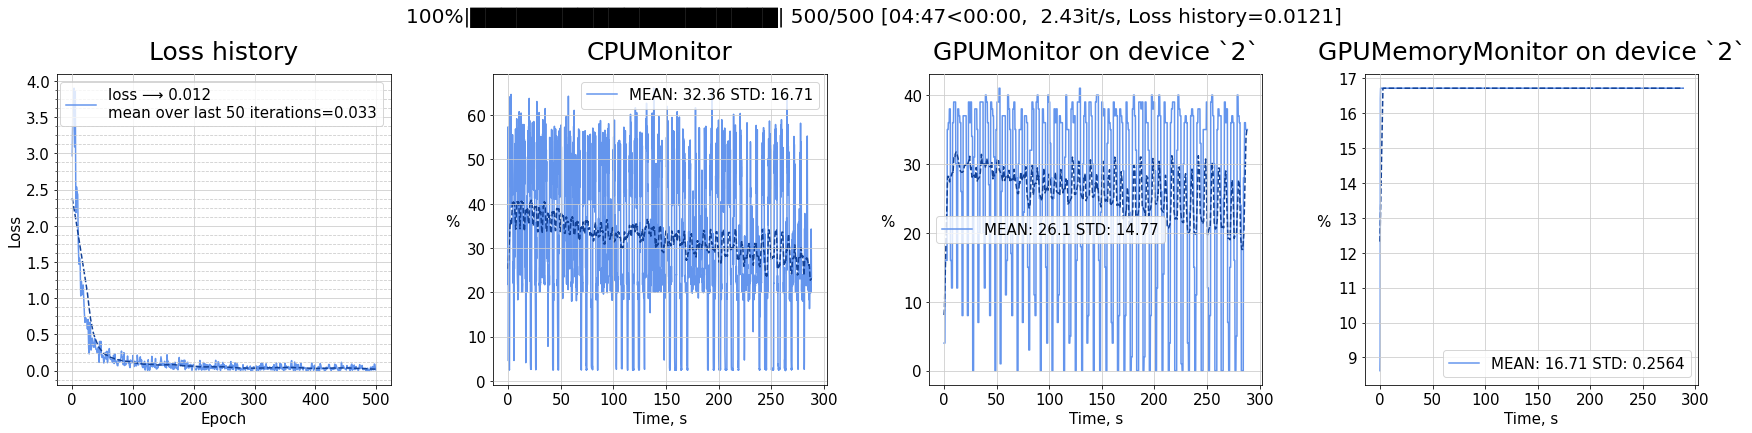

In [10]:
loss_history = []

notifier = Notifier(
    bar='n', frequency=10,
    graphs=[{'source': loss_history, 'name': 'Loss history', 'plot_config': {'xlabel': 'Epoch'}}, 'cpu', 'gpu', 'gpu_memory']
)

N_EPOCHS = 500

for epoch_num in notifier(N_EPOCHS):
    epoch_loss = []
    for batch in train_loader:
        inputs = batch['input_tensors'].to('cuda:0')
        embeddings = model(inputs)

        labels = batch['labels'].to(device)
        loss = criterion(embeddings, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_value = loss.detach().cpu().numpy().flatten()[0]
        epoch_loss.append(loss_value)
    loss_history.append(np.mean(epoch_loss))

Now let's get embeddings of train data, we'll need them for inference.

In [11]:
model.eval()

train_embeddings = []
train_labels = []

train_loader_ = torch.utils.data.DataLoader(train_dataset, batch_size=16, generator=generator)

for train_batch in Notifier('t')(train_loader_):
    train_inputs = train_batch['input_tensors'].to(device)
    train_batch_embeddings = model(train_inputs).detach().cpu().numpy()
    train_embeddings.append(train_batch_embeddings)
    train_labels.append(train_batch['labels'])
    
train_embeddings = np.vstack(train_embeddings)
train_labels = np.hstack(train_labels)

100%|███████████████████████████████████████████| 72/72 [00:03<00:00, 20.64it/s]


Make test dataset.

In [12]:
test_dataset = DatasetWithLabels(df=test_df, dataset_root='.', transform=transform, f_imread=imread_pillow)

Obtain test embeddings.

In [13]:
model.eval()

test_embeddings = []
test_labels = []

test_loader_ = torch.utils.data.DataLoader(test_dataset, batch_size=16, generator=generator)

for test_batch in Notifier('t')(test_loader_):
    test_inputs = test_batch['input_tensors'].to(device)
    test_batch_embeddings = model(test_inputs).detach().cpu().numpy()
    test_embeddings.append(test_batch_embeddings)
    test_labels.append(test_batch['labels'])
    
test_embeddings = np.vstack(test_embeddings)
test_labels = np.hstack(test_labels)

100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 18.31it/s]


Dump model to disk.

In [107]:
MODEL_PATH = f'../models/{NAME}_new.state'
# torch.save(model.state_dict(), MODEL_PATH)

Time for some numpy broadcasting tricks. Here we calculate all possible differences between train and test embedding vectors, choose `n_closest` for every test sample, count neighbours class labels and use the number of most frequent class as a prediction.

In [39]:
%%time

n_neighbours = 30
# calculate embeddings differences
diff = ((train_embeddings.reshape(1137, 1, 1000) - test_embeddings) ** 2).mean(axis=-1)
# choose closest ones
closest = train_labels[diff.argsort(axis=0)][:n_neighbours].T
# that's a clever 2d bincount trick found on stackoverflow
offsets = closest + np.arange(closest.shape[0])[:, None] * n_classes
counts = np.bincount(offsets.ravel(), minlength=closest.shape[0] * n_classes)
counts = counts.reshape(-1, n_classes)
# class of prevalent neighbours is our prediction
test_predictions = counts.argmax(axis=1)

CPU times: user 416 ms, sys: 240 ms, total: 656 ms
Wall time: 656 ms


Evaluation time! Surprisingly, metrics are not much better, even though EfficientNet_B2 is approx 9 times larger that VGG7.

Possible weak points of current solution are:
- Balanced sampling instead of semi-extreme
- No evaluation in-between training iterations, that probably means non-optimal train epochs number
- Custom inference technique that doesn't take into account actual cluster sizes (they are probably different, so constant 30 neigbours are definitely a bad thing)

Still, not bad.

,precision,recall
ArtDeco,50.0,30.0
Cubism,71.1,84.3
Impressionism,63.8,68.2
Japonism,67.7,60.0
Naturalism,73.3,62.3
Rococo,52.8,65.5
cartoon,53.3,50.0
photo,81.8,64.3


,accuracy,f1_score
altogether,67.0,62.3


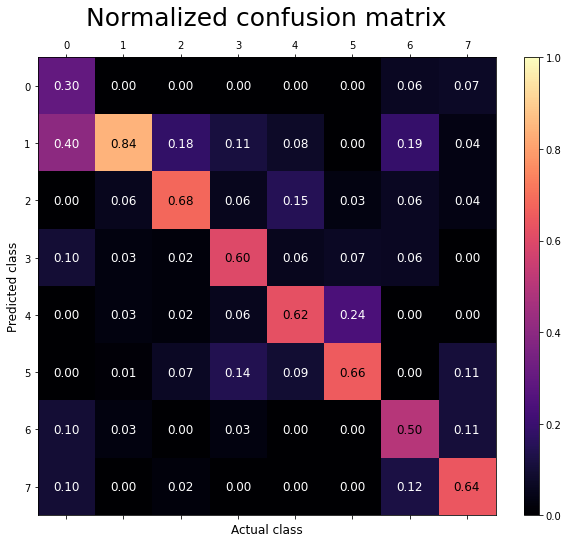

In [63]:
METRICS_PATH = f'../metrics/{NAME}.json'

evaluator = MetricsEvaluator(targets=test_labels, predictions=test_predictions, classes=classes)
classification_metrics = evaluator.evaluate_classification_metrics(show=True, savepath=METRICS_PATH)

Metrics saved for future comparison.

In [ ]:
from sklearn.manifold import TSNE
from batchflow.plotter.plot import Subplot

In [ ]:
tsne = TSNE(n_components=2, learning_rate=1, init='random', perplexity=3)
train_2d = tsne.fit_transform(train_embeddings)

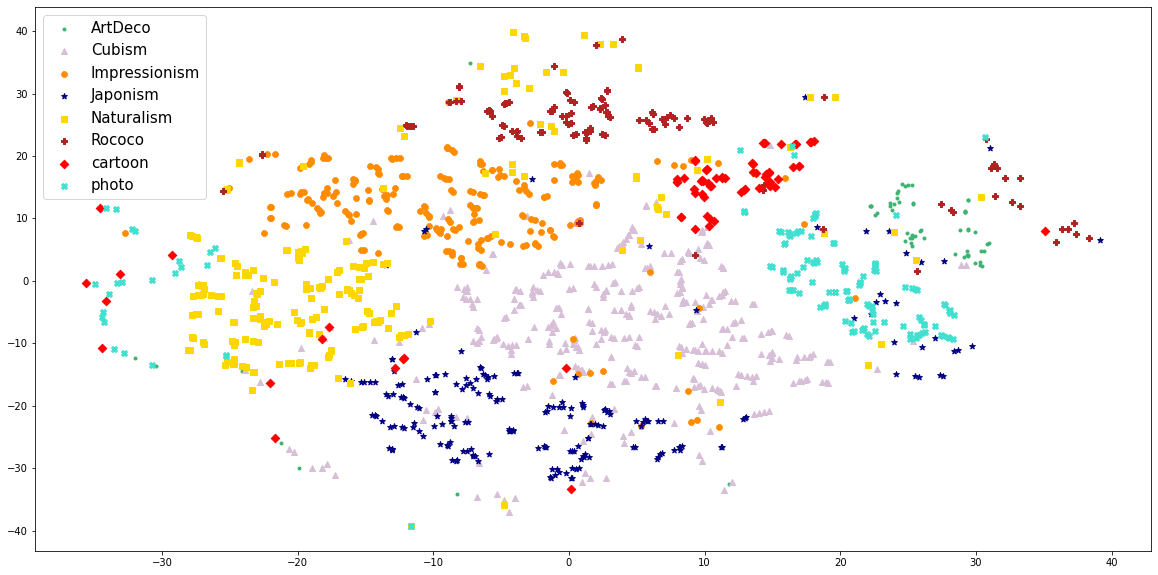

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

markers = ['.', '^', '8', '*', 's', 'P', 'D', 'X']
for index in range(n_classes):
    color = Subplot.MASK_COLORS[index]
    folded = [train_2d[train_labels == index], test_2d[test_labels == index]]
    folded = np.vstack(folded)
    ax.scatter(*folded.T, c=color, marker=markers[index])
    
ax.legend(classes, fontsize=15)

In [ ]:
tsne = TSNE(n_components=3, learning_rate=1, init='random', perplexity=3)
train_3d = tsne.fit_transform(train_embeddings)

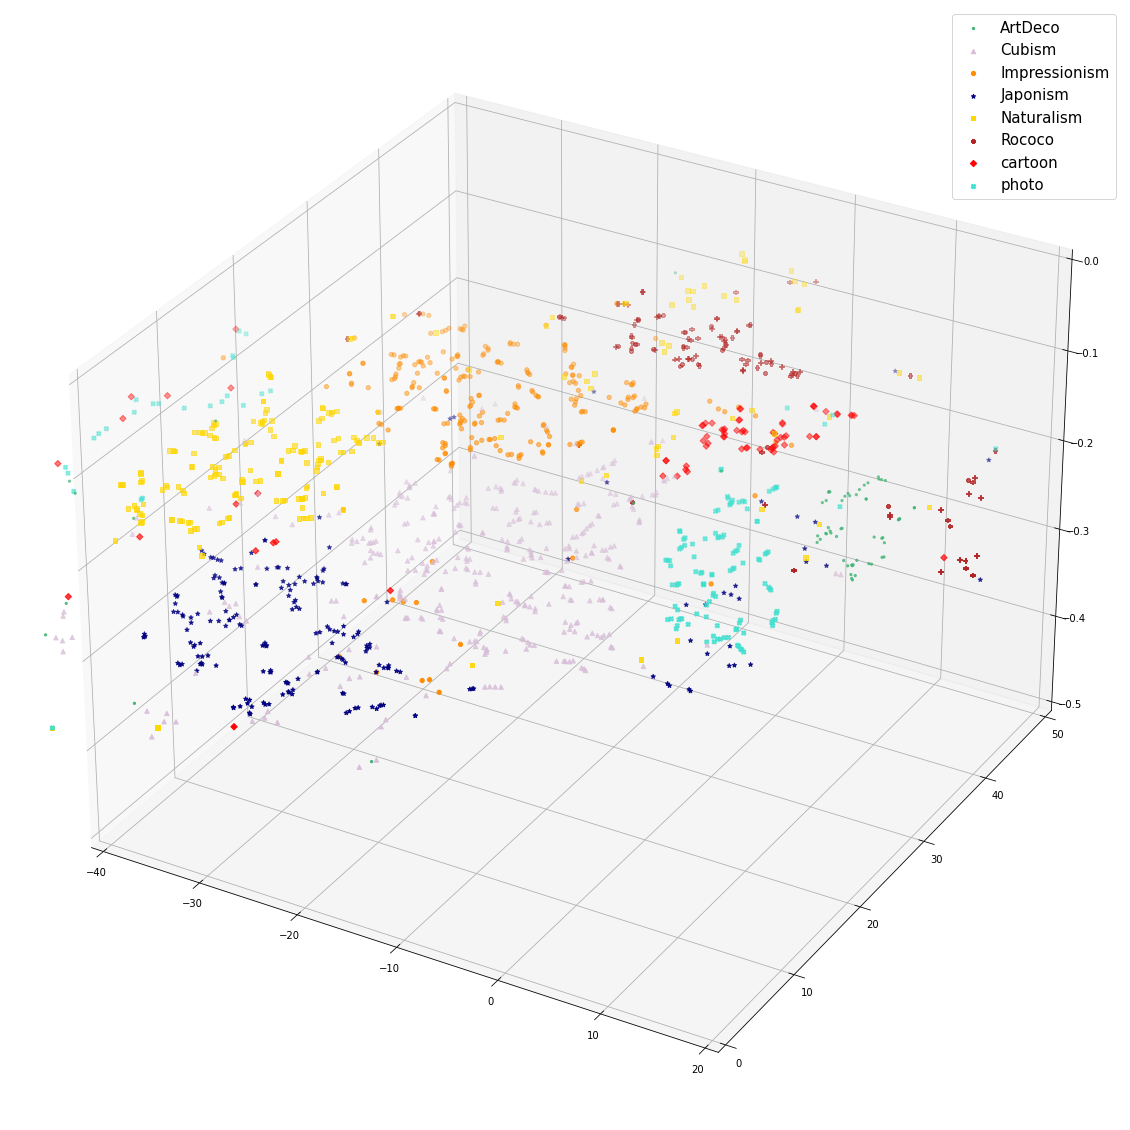

In [ ]:
fig = plt.figure(figsize=(20, 30))
ax = fig.add_subplot(projection='3d')

markers = ['.', '^', '8', '*', 's', 'P', 'D', 'X']
for index in range(n_classes):
    color = Subplot.MASK_COLORS[index]
    folded = [train_2d[train_labels == index], test_2d[test_labels == index]]
    folded = np.vstack(folded)
    ax.scatter(*folded.T, c=color, marker=markers[index])
    
ax.set_xlim(0, 100)
ax.set_ylim(0, 50)
ax.set_zlim(-300, 0)

ax.legend(classes, fontsize=15)